In [0]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [0]:
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 10
ZDIMS = 20

In [3]:
!mkdir hw9_data_self

mkdir: cannot create directory ‘hw9_data_self’: File exists


In [0]:
from torchvision import datasets, transforms

transformations = transforms.ToTensor()
mnist_train = datasets.MNIST(root='hw9_data_self', train=True, transform=transformations, target_transform=None, download=True)
mnist_test = datasets.MNIST(root='hw9_data_self', train=False, transform=transformations, target_transform=None, download=True)

In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)
        self.fc22 = nn.Linear(400, ZDIMS)
        self.fc3 = nn.Linear(ZDIMS, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:
model = VAE()

In [0]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 784
    return BCE + KLD

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [0]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    sample = Variable(torch.randn(64, ZDIMS))

    sample = model.decode(sample).cpu()
    save_image(sample.data.view(64, 1, 28, 28),
               'sample_' + str(epoch) + '.png')

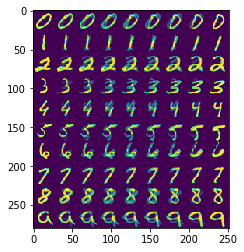

In [15]:
import matplotlib.pyplot as plt
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(len(y)):
    if y[i].item() not in similar_pairs:
      similar_pairs[y[i].item()] = []
    if len(similar_pairs[y[i].item()])<2:
      similar_pairs[y[i].item()].append(x[i])
  
  done = True
  for i in range(10):
    if i not in similar_pairs or len(similar_pairs[i])<2:
      done = False
  
  if done:
    break

full_pixels = []
middle = []


for i in range(10):
  middle.append([])
  first_array=similar_pairs[i][0][0]
  second_array=similar_pairs[i][1][0]
  for j in range(7):
    middle[i].append(first_array + (j+1)/8 * (second_array - first_array))

for i in range(10):

  first_array=similar_pairs[i][0][0]
  second_array=similar_pairs[i][1][0]  
  for j in range(len(first_array)):
      full_pixels.append([])
      full_pixels[-1] = first_array[j].tolist()
      for m in range(7):
        full_pixels[-1] = full_pixels[-1] + middle[i][m][j].tolist()
      full_pixels[-1] = full_pixels[-1] + second_array[j].tolist()

plt.imshow(full_pixels)
plt.show()

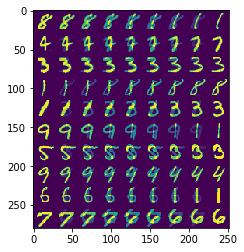

In [16]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
  for i in range(10):
    random_pairs[i] = []
    random_pairs[i].append(x[2*i])
    random_pairs[i].append(x[2*i+1])
  break

full_pixels_2 = []
middle_2 = []


for i in range(10):
  middle_2.append([])
  first_array=random_pairs[i][0][0]
  second_array=random_pairs[i][1][0]
  for j in range(7):
    middle_2[i].append(first_array + (j+1)/8 * (second_array - first_array))

for i in range(10):

  first_array=random_pairs[i][0][0]
  second_array=random_pairs[i][1][0]  
  for j in range(len(first_array)):
      full_pixels_2.append([])
      full_pixels_2[-1] = first_array[j].tolist()
      for m in range(7):
        full_pixels_2[-1] = full_pixels_2[-1] + middle_2[i][m][j].tolist()
      full_pixels_2[-1] = full_pixels_2[-1] + second_array[j].tolist()


plt.imshow(full_pixels_2)
plt.show()